In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/LCDataDictionary.xlsx
/kaggle/input/credit-risk-dataset/loan/loan.csv
/kaggle/input/processed-dataset-for-cra/processed_df.csv


In [2]:
#importing helping hands
import os
import time
from collections import Counter

import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
df_loan = pd.read_csv("/kaggle/input/processed-dataset-for-cra/processed_df.csv")

# Initial Analysis

In [4]:
df_loan.columns.to_list()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'revol_util',
 'total_acc',
 'total_rev_hi_lim',
 'term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type']

In [5]:
df_loan.isnull().sum()

loan_amnt                 0
funded_amnt               0
funded_amnt_inv           0
int_rate                  0
dti                       0
delinq_2yrs               0
inq_last_6mths            0
mths_since_last_delinq    0
open_acc                  0
revol_util                0
total_acc                 0
total_rev_hi_lim          0
term                      0
grade                     0
sub_grade                 0
emp_length                0
home_ownership            0
verification_status       0
issue_d                   0
loan_status               0
pymnt_plan                0
purpose                   0
zip_code                  0
addr_state                0
earliest_cr_line          0
initial_list_status       0
last_pymnt_d              0
next_pymnt_d              0
last_credit_pull_d        0
application_type          0
dtype: int64

In [6]:
df_loan.T

,0,1,2,3,4,5,6,7,8,9,...,291300,291301,291302,291303,291304,291305,291306,291307,291308,291309
loan_amnt,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,4000.00,14000.00,10000.00,...,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17
funded_amnt,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,4000.00,14000.00,10000.00,...,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17
funded_amnt_inv,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,3950.00,14000.00,10000.00,...,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86
int_rate,6.62,9.67,14.98,19.22,13.53,16.24,17.57,7.90,14.98,11.99,...,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62
dti,14.05,15.55,3.73,16.23,22.56,10.68,18.51,15.47,14.59,10.47,...,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74
delinq_2yrs,0.00,2.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46
inq_last_6mths,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,...,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45
mths_since_last_delinq,43.00,11.00,16.00,10.00,45.00,10.00,64.00,50.00,41.00,34.00,...,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14
open_acc,12.00,9.00,9.00,5.00,12.00,7.00,17.00,10.00,15.00,11.00,...,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05
revol_util,21.60,44.40,66.20,93.10,39.60,51.60,88.20,61.20,81.60,65.30,...,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93


# Feature Engineering

#### Transforming some variables

In [7]:
df_loan['grade'] = df_loan['grade'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G'], [0, 1, 2, 3, 4, 5, 6])
df_loan['sub_grade'] = df_loan['sub_grade'].str.strip('ABCDEFG').astype('float64')
df_loan['emp_length'] = df_loan['emp_length'].str.strip(' <years')
df_loan['emp_length'] = df_loan['emp_length'].replace('10+',11).astype('float64')

In [8]:
df_loan[['Issue Month','Issue Year']] = df_loan.issue_d.str.split("-",expand=True)
df_loan[['Earliest Credit Month', 'Earliest Credit Year']] = df_loan.earliest_cr_line.str.split("-",expand=True)

df_loan['Issue Year'] = df_loan['Issue Year'].astype('int32')
df_loan['Earliest Credit Year'] = df_loan['Earliest Credit Year'].astype('int32')
   
df_loan = df_loan.drop(labels=['issue_d', 'earliest_cr_line'], axis=1)

#### Transforming dates further

In [9]:
# select date columns
date_columns = [ 
    'last_pymnt_d', 
    'last_credit_pull_d',
    'next_pymnt_d'
]

# drop rows whose date is NaN
df_loan = df_loan.dropna(subset=date_columns)
df_loan = df_loan.reset_index(drop=True)

# format dates
for col in date_columns:
    df_loan.loc[:, col] = pd.to_datetime(df_loan[col])

df_loan[date_columns].head()

,last_pymnt_d,last_credit_pull_d,next_pymnt_d
0,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00
1,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00
2,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00
3,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00
4,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00


In [10]:
df_loan.T

,0,1,2,3,4,5,6,7,8,9,...,291300,291301,291302,291303,291304,291305,291306,291307,291308,291309
loan_amnt,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,4000.00,14000.00,10000.00,...,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17
funded_amnt,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,4000.00,14000.00,10000.00,...,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17
funded_amnt_inv,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,3950.00,14000.00,10000.00,...,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86
int_rate,6.62,9.67,14.98,19.22,13.53,16.24,17.57,7.90,14.98,11.99,...,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62
dti,14.05,15.55,3.73,16.23,22.56,10.68,18.51,15.47,14.59,10.47,...,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74
delinq_2yrs,0.00,2.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46
inq_last_6mths,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,...,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45
mths_since_last_delinq,43.00,11.00,16.00,10.00,45.00,10.00,64.00,50.00,41.00,34.00,...,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14
open_acc,12.00,9.00,9.00,5.00,12.00,7.00,17.00,10.00,15.00,11.00,...,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05
revol_util,21.60,44.40,66.20,93.10,39.60,51.60,88.20,61.20,81.60,65.30,...,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93


#### Formatting target variable

In [11]:
df_loan['loan_status'].unique()

array(['Current', 'Late (31-120 days)', 'Late (16-30 days)',
       'In Grace Period', 'Default', 'Issued'], dtype=object)

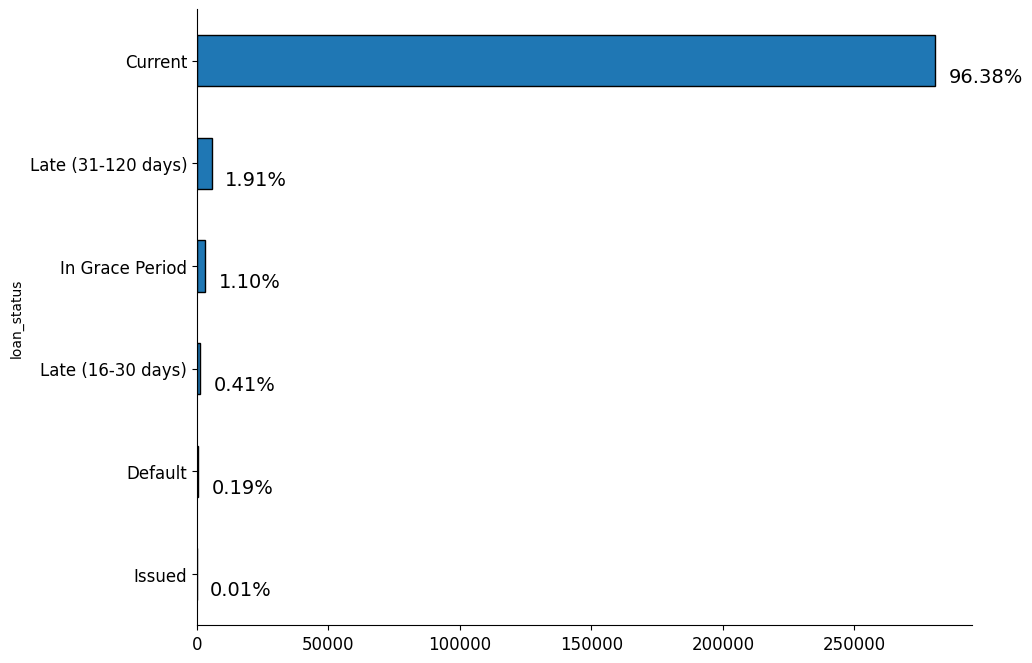

In [12]:
plt.figure(figsize=(10,8))

ax = df_loan['loan_status'].value_counts().sort_values().plot.barh(edgecolor='black', grid=False, fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.text(width+5000, p.get_y(), '{:.2%}'.format(width/len(df_loan)), ha='left', va='bottom', fontsize=14)

sns.despine() 

In [13]:
# removed the 'Issued' class since these loans just got approved and have not begun any repayment processes yet
issue = df_loan['loan_status'] == 'Issued'
df_loan_issue = df_loan[~issue]

# binary classification
label_categories = [
    (0, ['Current']),
    (1, ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period','Default'])
]

# function to apply the transformation
def classify_label(text):
    for category, matches in label_categories:
        if any(match in text for match in matches):
            return category
    return None

df_loan_issue.loc[:, 'label'] = df_loan_issue['loan_status'].apply(classify_label)
df_loan_issue = df_loan_issue.drop('loan_status', axis=1)

# check label classes imbalance
neg, pos = np.bincount(df_loan_issue['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 291293
    Positive: 10528 (3.61% of total)



#### Formatting other columns
##### - Home ownership

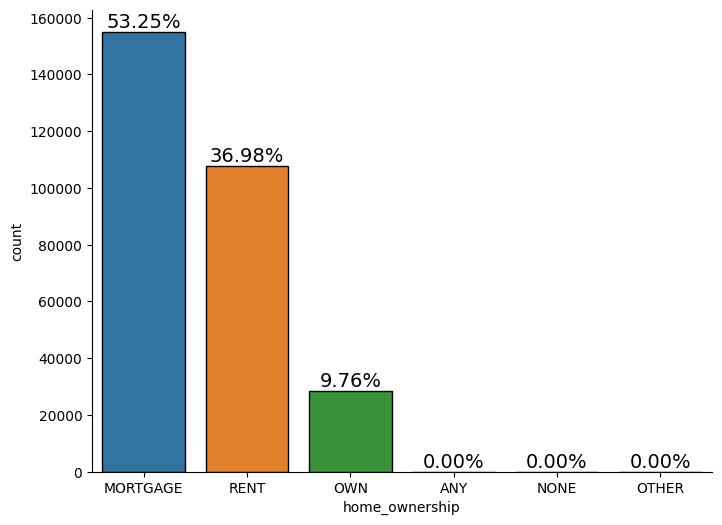

In [14]:
plt.figure(figsize=(8,6))

ax = sns.countplot(x='home_ownership', data=df_loan_issue, edgecolor='black')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+.4, height, '{:.2%}'.format(height/len(df_loan)), ha='center', va='bottom', fontsize=14)

sns.despine()

In [15]:
df_loan_issue['home_ownership'] = df_loan_issue['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

#### Ordinal Coding

In [16]:
df_loan_issue['term'] = pd.factorize(df_loan_issue['term'])[0]
df_loan_issue['sub_grade'] = pd.factorize(df_loan_issue['sub_grade'])[0]


In [17]:
df_loan_issue['emp_length'] = pd.factorize(df_loan_issue['emp_length'])[0]
df_loan_issue['home_ownership'] = pd.factorize(df_loan_issue['home_ownership'])[0]
df_loan_issue['purpose'] = pd.factorize(df_loan_issue['purpose'])[0]
df_loan_issue['verification_status'] = pd.factorize(df_loan_issue['verification_status'])[0]

In [18]:
df_loan_issue['addr_state'] = pd.factorize(df_loan_issue['addr_state'])[0]

In [19]:
df_loan_issue['initial_list_status'] = pd.factorize(df_loan_issue['initial_list_status'])[0]

##### - Label encding payment plan

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_loan_issue['pymnt_plan'] = label_encoder.fit_transform(df_loan_issue['pymnt_plan'])

##### - Dropping zipcode

In [21]:
# pymnt_plan has only zeros. application_type contains mostly one value
df_loan_issue = df_loan_issue.drop(columns=['zip_code'])
df_loan_issue = df_loan_issue.drop(columns=['application_type'])


In [22]:
df_loan_issue.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291293 entries, 0 to 291309
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               291293 non-null  float64
 1   funded_amnt             291293 non-null  float64
 2   funded_amnt_inv         291293 non-null  float64
 3   int_rate                291293 non-null  float64
 4   dti                     291293 non-null  float64
 5   delinq_2yrs             291293 non-null  float64
 6   inq_last_6mths          291293 non-null  float64
 7   mths_since_last_delinq  291293 non-null  float64
 8   open_acc                291293 non-null  float64
 9   revol_util              291293 non-null  float64
 10  total_acc               291293 non-null  float64
 11  total_rev_hi_lim        291293 non-null  float64
 12  term                    291293 non-null  int64  
 13  grade                   291293 non-null  int64  
 14  sub_grade               2

In [23]:
df_loan_issue.T

,0,1,2,3,4,5,6,7,8,9,...,291300,291301,291302,291303,291304,291305,291306,291307,291308,291309
loan_amnt,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,4000.00,14000.00,10000.00,...,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17
funded_amnt,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,4000.00,14000.00,10000.00,...,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17
funded_amnt_inv,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,3950.00,14000.00,10000.00,...,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86
int_rate,6.62,9.67,14.98,19.22,13.53,16.24,17.57,7.90,14.98,11.99,...,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62
dti,14.05,15.55,3.73,16.23,22.56,10.68,18.51,15.47,14.59,10.47,...,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74
delinq_2yrs,0.00,2.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46
inq_last_6mths,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,...,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45
mths_since_last_delinq,43.00,11.00,16.00,10.00,45.00,10.00,64.00,50.00,41.00,34.00,...,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14
open_acc,12.00,9.00,9.00,5.00,12.00,7.00,17.00,10.00,15.00,11.00,...,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05
revol_util,21.60,44.40,66.20,93.10,39.60,51.60,88.20,61.20,81.60,65.30,...,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93


##### Converting timestamp columns to numeric

In [24]:
df_loan_issue['last_pymnt_d_timestamp'] = pd.to_datetime(df_loan_issue['last_pymnt_d'])
df_loan_issue['next_pymnt_d_timestamp'] = pd.to_datetime(df_loan_issue['next_pymnt_d'])
df_loan_issue['last_credit_pull_d_timestamp'] = pd.to_datetime(df_loan_issue['last_credit_pull_d'])

df_loan_issue['last_pymnt_d_numeric'] = df_loan_issue['last_pymnt_d_timestamp'].astype(int)
df_loan_issue['next_pymnt_d_numeric'] = df_loan_issue['next_pymnt_d_timestamp'].astype(int)
df_loan_issue['last_credit_pull_d_numeric'] = df_loan_issue['last_credit_pull_d_timestamp'].astype(int)

In [25]:
columns_to_drop = ['last_pymnt_d_timestamp', 'next_pymnt_d_timestamp', 'last_credit_pull_d_timestamp', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

df_loan_issue = df_loan_issue.drop(columns=columns_to_drop)

#### Month encoding to use features - Issue Month, Earliest Credit Month

In [26]:
month_encoding = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

df_loan_issue['issue_month_encoded'] = df_loan_issue['Issue Month'].map(month_encoding)
df_loan_issue['earliest_credit_month_encoded'] = df_loan_issue['Earliest Credit Month'].map(month_encoding)

In [27]:
columns_to_drop = ['Issue Month', 'Earliest Credit Month']

df_loan_issue = df_loan_issue.drop(columns=columns_to_drop)

In [28]:
df_loan_issue.T

,0,1,2,3,4,5,6,7,8,9,...,291300,291301,291302,291303,291304,291305,291306,291307,291308,291309
loan_amnt,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,4000.00,14000.00,10000.00,...,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17
funded_amnt,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,4000.00,14000.00,10000.00,...,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17,13297.17
funded_amnt_inv,12000.00,10000.00,11100.00,4500.00,5000.00,12000.00,10400.00,3950.00,14000.00,10000.00,...,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86,13291.86
int_rate,6.62,9.67,14.98,19.22,13.53,16.24,17.57,7.90,14.98,11.99,...,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62,12.62
dti,14.05,15.55,3.73,16.23,22.56,10.68,18.51,15.47,14.59,10.47,...,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74,18.74
delinq_2yrs,0.00,2.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46
inq_last_6mths,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,...,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45
mths_since_last_delinq,43.00,11.00,16.00,10.00,45.00,10.00,64.00,50.00,41.00,34.00,...,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14,34.14
open_acc,12.00,9.00,9.00,5.00,12.00,7.00,17.00,10.00,15.00,11.00,...,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05,11.05
revol_util,21.60,44.40,66.20,93.10,39.60,51.60,88.20,61.20,81.60,65.30,...,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93,56.93


In [29]:
df_final = df_loan_issue.copy()

# Modeling

In [30]:
# scikeras library requires tensorflow >= 2.7.0
!pip install -U tensorflow==2.7.0
!pip install -U scikeras

ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.7.0
  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

#### Splitting the data

In [32]:
# split train test set
train, test = train_test_split(df_loan_issue, test_size=0.2, stratify=df_loan_issue['label'], random_state=42)

y_train = train.pop('label')
y_test = test.pop('label')
X_train = train
X_test = test

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((233034, 29), (233034,)), ((58259, 29), (58259,)))

#### Normalizing Data

In [33]:
# normalize data
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# set metrics to track
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), 
]

# function to build simple dnn
def make_model(metrics, size):
    model = keras.Sequential([
        keras.layers.Dense(
            16, 
            activation='relu', 
            input_shape=(size,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(
            8, 
            activation='relu'),
        keras.layers.Dropout(0.5),        
        keras.layers.Dense(
            1, 
            activation='sigmoid'),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
    return model

In [35]:
# find the class weight to handle unbalanced label classes
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 13.83


In [36]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [37]:
model_base = make_model(metrics=METRICS, size=X_train_scaled.shape[-1])

classifier_base = KerasClassifier(model=model_base,
                                  epochs=EPOCHS,
                                  batch_size=BATCH_SIZE,
                                  callbacks=[early_stopping],
                                  validation_split=0.1,
                                  verbose=0)

classifier_base.fit(X_train_scaled, y_train, class_weight=class_weight)

Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping


KerasClassifier(
	model=<keras.src.engine.sequential.Sequential object at 0x7ad3b3bfa9b0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=2048
	validation_batch_size=None
	verbose=0
	callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7ad3b4213ca0>]
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

29/29 [==============================] - 0s 2ms/step
loss :  0.33089134097099304
accuracy :  0.8814947009086609
precision :  0.20743902027606964
recall :  0.807692289352417
auc :  0.9224873185157776
prc :  0.6526882648468018



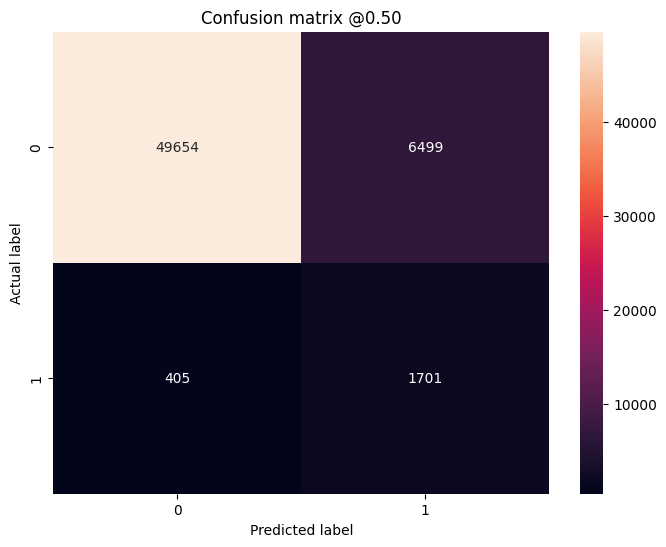

In [38]:
# results output
def plot_cm(labels, predictions, p=0.5):
    plt.figure(figsize=(8,6))
    
    cm = confusion_matrix(labels, predictions > p)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

prediction_base = model_base.predict(X_test_scaled, batch_size=BATCH_SIZE)
evaluation_base = model_base.evaluate(X_test_scaled, y_test, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_base.metrics_names, evaluation_base):
    print(name, ': ', value)
print()

plot_cm(y_test, prediction_base)

#### Checking the correlation

<Axes: >

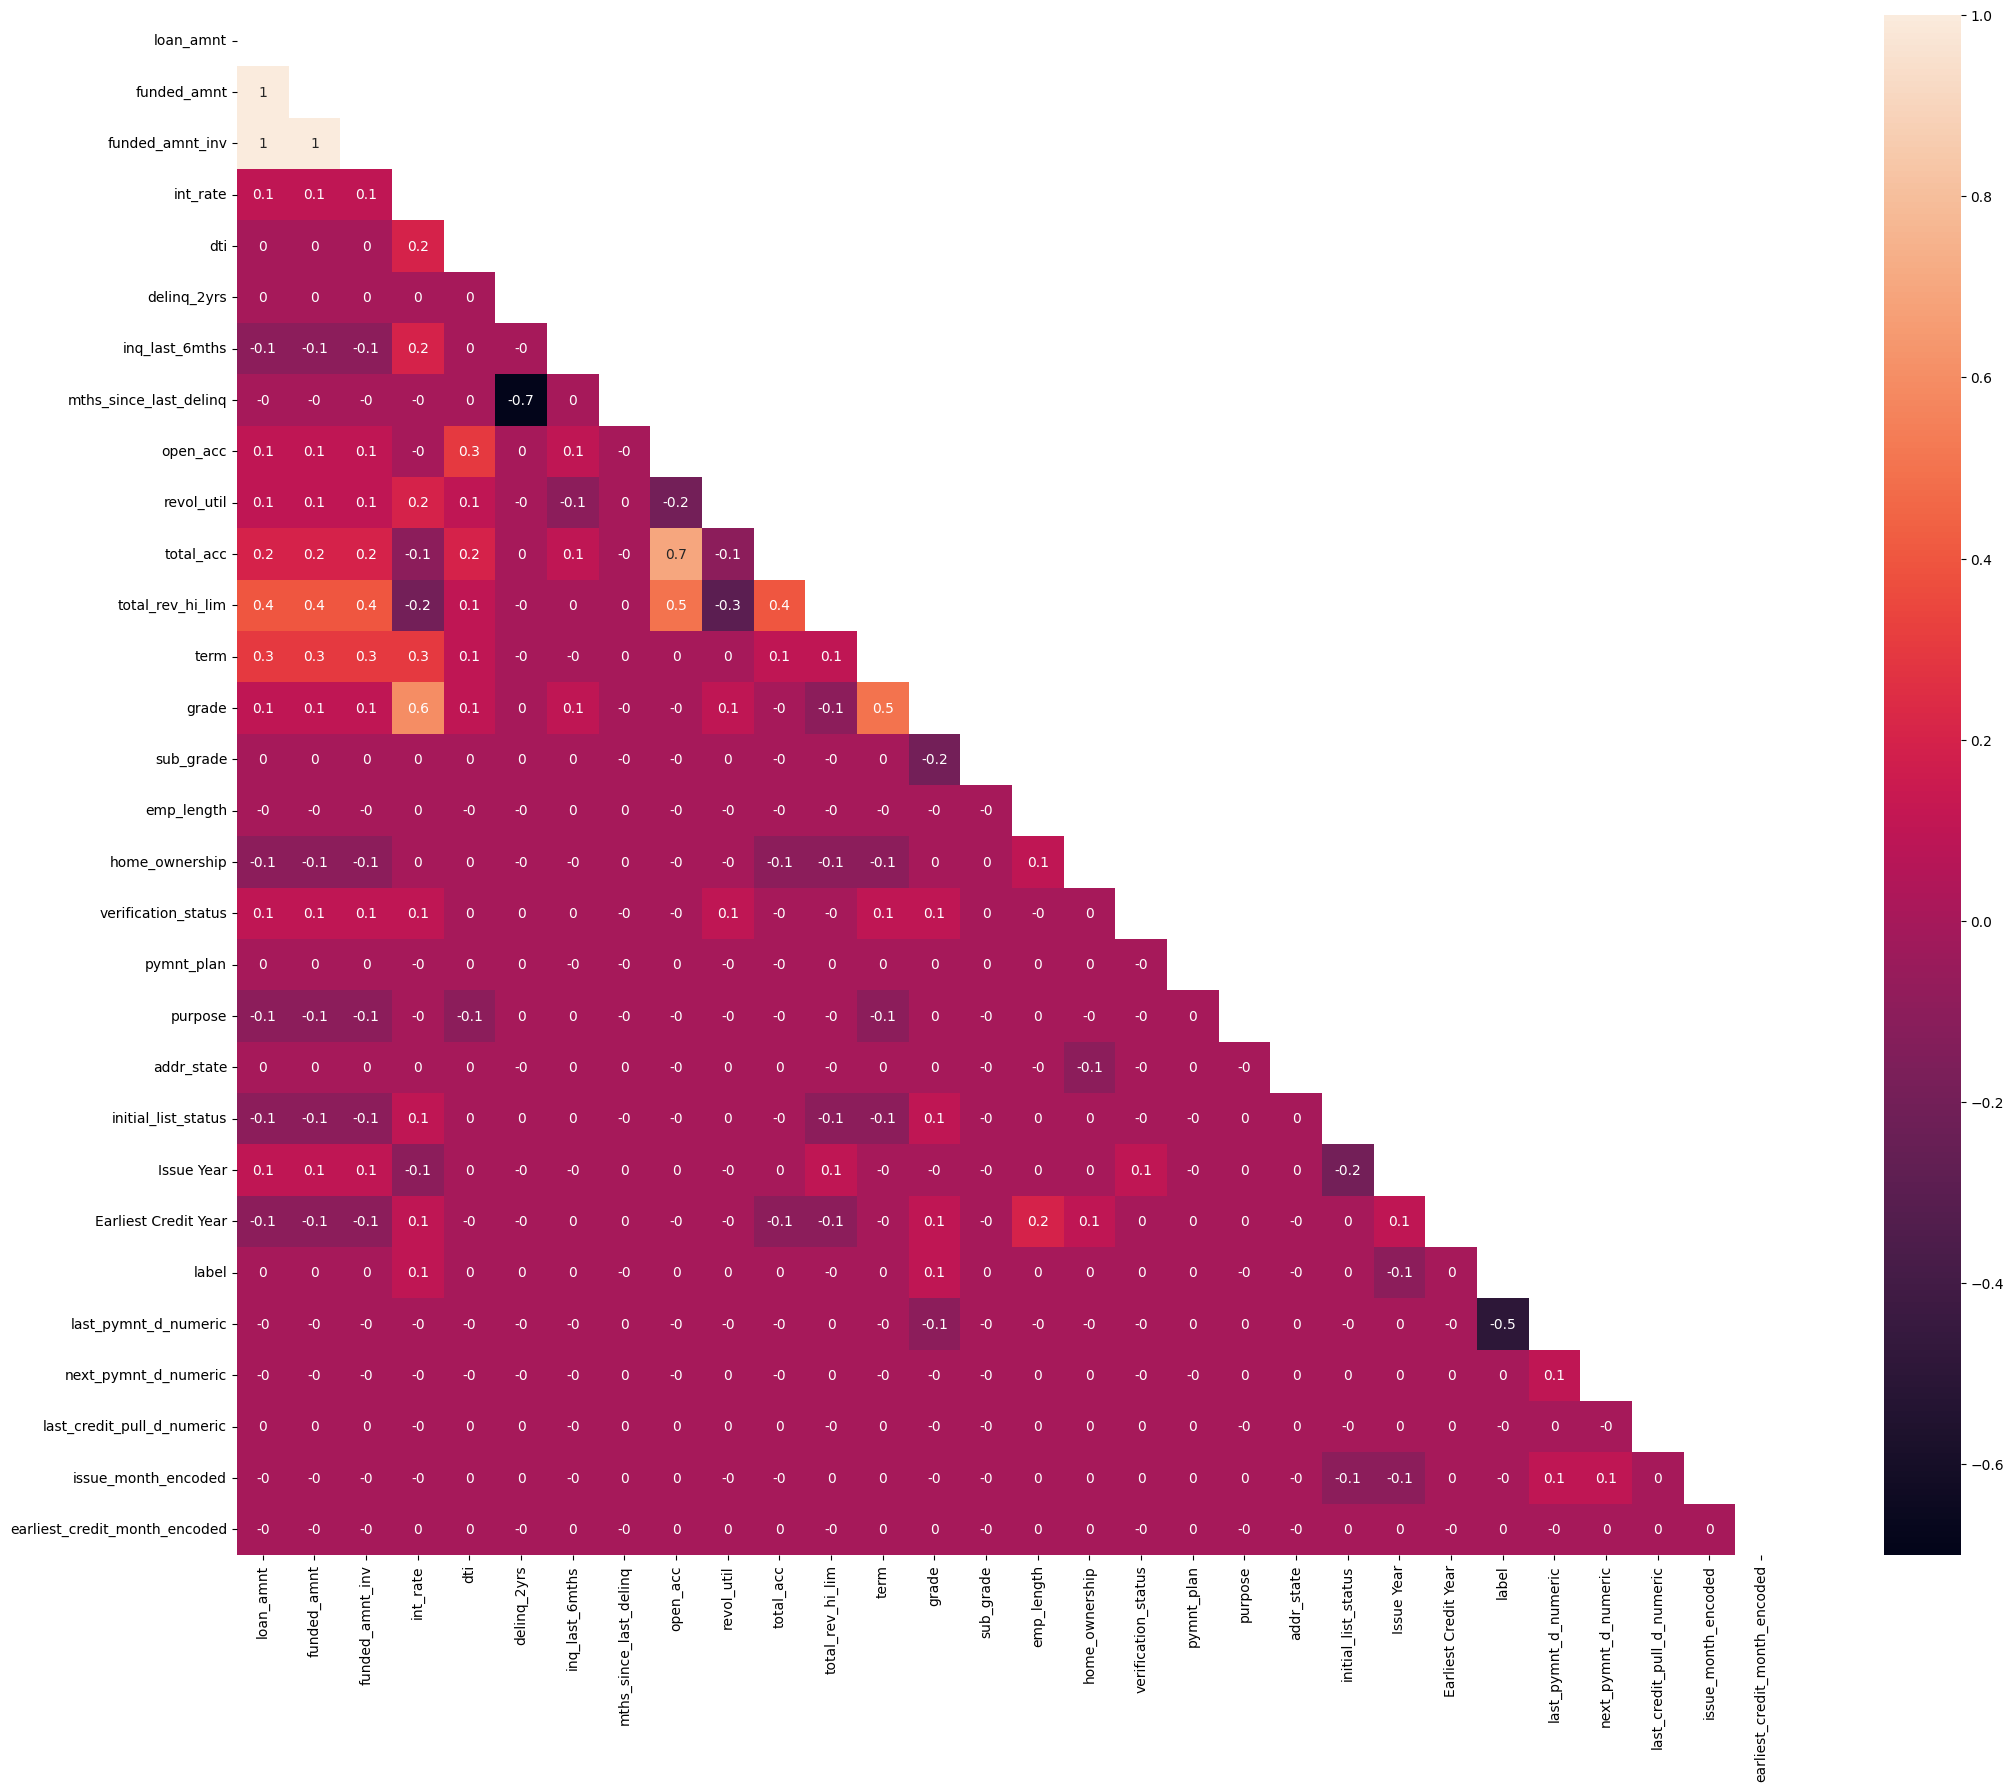

In [39]:
# checking correlations
corr = df_final.corr().round(1)

plt.figure(figsize=(25,20))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask, cbar=True)

#### Plotting the ROC and the AUC curve

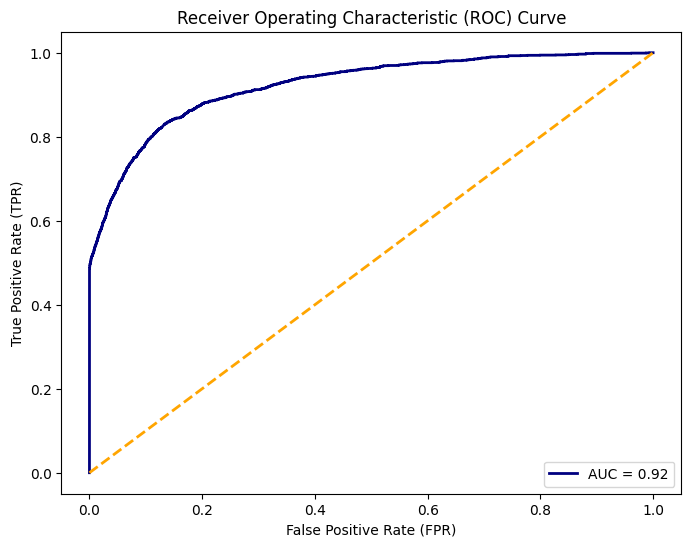

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ...

# Predictions on the test set
prediction_base = classifier_base.predict(X_test_scaled)

# Get predicted probabilities for the positive class
y_scores_base = classifier_base.predict_proba(X_test_scaled)[:, 1]

# Plot ROC curve
fpr_base, tpr_base, _ = roc_curve(y_test, y_scores_base)
roc_auc_base = auc(fpr_base, tpr_base)

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, color='navy', lw=2, label=f'AUC = {roc_auc_base:.2f}')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Thank you!